# LIGHTGBM MODELO SELECCIONADO

**Objetivo:** Entrenar LightGBM optimizado en TRAIN y evaluar en TEST para las 3 fases temporales (T0, T1, T2), con luego aplicar la explicabilidad mediante SHAP.

**IMPORTANTE:** Este notebook se ejecuta UNA SOLA VEZ. Los resultados de TEST son el reporte final.

Fases temporales:
- T0 (Matrícula)          : Variables disponibles al momento de inscripción
- T1 (Fin 1er Semestre)   : T0 + variables académicas del 1er semestre, información de matrícula y deudor
- T2 (Fin 2do Semestre)   : T1 + variables académicas del 2do semestre

Preprocesamiento específico para LightGBM:
- No requiere escalado
- Label Encoding para categóricas
- Target Encoding para 'course'

Pipeline:
1. Cargar datos y mejores hiperparámetros de Optuna resultantes de etapa de entrenamiento con validación cruzada
2. Entrenar modelo final en X_train completo
3. Evaluar en X_test 
4. Comparación entre fases T0, T1, T2
5. Guardar modelos finales para producción

## 0. Librerias y configuración

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
import json
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder

# Modelo
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# Target Encoding
from category_encoders import TargetEncoder

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorio de salida
OUTPUT_DIR = "../outputs/figures/modelado/LightGBM/"
OUTPUT_DIR_MODELS = "../outputs/models/LightGBM/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)

# mlflow
import mlflow
import mlflow.sklearn

## 1. Carga de datos preprocesados

In [22]:
# Cargar dataset preprocesado
df = pd.read_csv('../data/processed/preprocessed_data.csv')

print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
print(df['target_binario'].value_counts())
print(f"\nRatio de desbalance: {df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]:.2f}:1")

df.head()

Dataset cargado: 4424 filas x 36 columnas
target_binario
0    3003
1    1421
Name: count, dtype: int64

Ratio de desbalance: 2.11:1


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,target_binario
0,5,171,1,122.0000,127.3000,1,0,0,1,1,0,20,0,0,0,0,0,0.0000,0,0,0,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,1
1,1,9254,1,160.0000,142.5000,1,0,0,0,1,0,19,0,0,6,6,6,14.0000,0,0,6,6,6,13.6667,0,13.9000,-0.3000,0.7900,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0
2,5,9070,1,122.0000,124.8000,1,0,0,0,1,0,19,0,0,6,0,0,0.0000,0,0,6,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1
3,2,9773,1,122.0000,119.6000,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4000,0,9.4000,-0.8000,-3.1200,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0
4,1,8014,0,100.0000,141.5000,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0000,0,13.9000,-0.3000,0.7900,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0


## 2. Definición de variables por fase temporal (T0, T1, T2)

In [23]:
# TARGET
TARGET = 'target_binario'

# -----------------------------------------------------------------------------
# VARIABLES BINARIAS (no requieren encoding, ya son 0/1)
# -----------------------------------------------------------------------------
VARS_BINARIAS_T0 = [
    'daytimeevening_attendance',
    'displaced',
    'educational_special_needs',
    'gender',
    'scholarship_holder',
    'international',
    'is_single'
]

VARS_BINARIAS_T1 = [
    'debtor',
    'tuition_fees_up_to_date'
]


# -----------------------------------------------------------------------------
# VARIABLES NUMÉRICAS (NO requieren escalado para LightGBM)
# -----------------------------------------------------------------------------
VARS_NUMERICAS_T0 = [
    'age_at_enrollment',
    'admission_grade',
    'previous_qualification_grade'
]

VARS_NUMERICAS_T1 = [
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

VARS_NUMERICAS_T2 = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS AGRUPADAS (requieren Label Encoding para LightGBM)
# -----------------------------------------------------------------------------
VARS_CATEGORICAS_AGRUPADAS_T0 = [
    'application_mode_risk',
    'previous_qualification_risk',
    'mothers_qualification_level',
    'fathers_qualification_level',
    'mothers_occupation_level',
    'fathers_occupation_level'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS PARA TARGET ENCODING
# -----------------------------------------------------------------------------
VARS_TARGET_ENCODING_T0 = ['course']

# -----------------------------------------------------------------------------
# VARIABLE ORDINAL (se trata como numérica)
# -----------------------------------------------------------------------------
VARS_ORDINALES_T0 = ['application_order']

# =============================================================================
# COMPOSICIÓN DE VARIABLES POR FASE TEMPORAL
# =============================================================================

# T0: Variables disponibles al momento de matrícula
VARS_T0 = (
    VARS_BINARIAS_T0 +
    VARS_NUMERICAS_T0 +
    VARS_CATEGORICAS_AGRUPADAS_T0 +
    VARS_TARGET_ENCODING_T0 +
    VARS_ORDINALES_T0
)

# T1: T0 + variables del 1er semestre
VARS_T1 = (
    VARS_T0 +
    VARS_BINARIAS_T1 +
    VARS_NUMERICAS_T1
)

# T2: T1 + variables del 2do semestre
VARS_T2 = (
    VARS_T1 +
    VARS_NUMERICAS_T2
)

print("================================================================================")
print("  VARIABLES POR FASE TEMPORAL")
print("================================================================================")
print(f"\n T0 (Matrícula): {len(VARS_T0)} variables")
print(f" T1 (Fin 1er Sem): {len(VARS_T1)} variables (+{len(VARS_T1) - len(VARS_T0)})")
print(f" T2 (Fin 2do Sem): {len(VARS_T2)} variables (+{len(VARS_T2) - len(VARS_T1)})")

  VARIABLES POR FASE TEMPORAL

 T0 (Matrícula): 18 variables
 T1 (Fin 1er Sem): 29 variables (+11)
 T2 (Fin 2do Sem): 35 variables (+6)


## 3. Split Train/Test

In [24]:
# Split se hace en totalidad del dataste, posteriormente se seleccionan las variables según la fase temporal para entrenemiento y evaluación

X = df[VARS_T2].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


print("================================================================================")
print("  DATOS PARA ENTRENAMIENTO")
print("================================================================================")
print(f"\nTotal registros: {X.shape[0]}")
print(f"Total variables: {X.shape[1]}")

print(f"\nDistribución del target:")
print(y.value_counts())
print(f"Ratio de desbalance: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

  DATOS PARA ENTRENAMIENTO

Total registros: 4424
Total variables: 35

Distribución del target:
target_binario
0    3003
1    1421
Name: count, dtype: int64
Ratio de desbalance: 2.11:1


## 4. Funciones de preprocesamiento para LightGBM

In [25]:
def obtiene_variables_por_fase(fase):
    # Retorna las listas de variables según la fase temporal, retorna diccionario con variables de la fase
    if fase == 'T0':
        return {
            'binarias': VARS_BINARIAS_T0,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T0
        }
    elif fase == 'T1':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T1
        }
    elif fase == 'T2':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1 + VARS_NUMERICAS_T2,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T2
        }
    else:
        raise ValueError(f"Fase no válida: {fase}. Usar 'T0', 'T1', o 'T2'")


def preprocesamiento_lightgbm(X_train, X_test, y_train, fase):
    # Preprocesa los datos para LightGBM    
    variables_fase = obtiene_variables_por_fase(fase)
    
    # Seleccionar solo las variables de la fase
    X_train_fase = X_train[variables_fase['all']].copy()
    X_test_fase = X_test[variables_fase['all']].copy()
    
    # Diccionario para guardar encoders
    label_encoders = {}
    
    # -------------------------------------------------------------------------
    # 1. TARGET ENCODING para 'course' 
    # -------------------------------------------------------------------------
    te = TargetEncoder(cols=variables_fase['categoricas_te'], smoothing=0.3)
    
    for col in variables_fase['categoricas_te']:
        X_train_fase[col + '_encoded'] = te.fit_transform(X_train_fase[[col]], y_train)[col]
        X_test_fase[col + '_encoded'] = te.transform(X_test_fase[[col]])[col]
        # Eliminar columna original
        X_train_fase = X_train_fase.drop(columns=[col])
        X_test_fase = X_test_fase.drop(columns=[col])
    
    # -------------------------------------------------------------------------
    # 2. LABEL ENCODING para categóricas agrupadas
    # -------------------------------------------------------------------------
    for col in variables_fase['categoricas_le']:
        le = LabelEncoder()
        X_train_fase[col] = le.fit_transform(X_train_fase[col].astype(str))
        X_test_fase[col] = le.transform(X_test_fase[col].astype(str))
        label_encoders[col] = le
    
    # -------------------------------------------------------------------------
    # Guardar información
    # -------------------------------------------------------------------------
    variables = X_train_fase.columns.tolist()
    preprocessors = {
        'target_encoder': te,
        'label_encoders': label_encoders,
        'feature_names': variables
    }
    
    return X_train_fase, X_test_fase, preprocessors



In [26]:
# MEJORES HIPERPARÁMETROS DE OPTUNA 
BEST_PARAMS = {
    'T0': {
       	'n_estimators' : 20,
        'learning_rate' : 0.2063435557391993,
        'num_leaves' : 106,
        'max_depth' : 10,
        'min_child_samples' : 53,
        'subsample' : 0.9745894053394364,
        'colsample_bytree' : 0.6367900490037547,
        'reg_alpha' : 9.065587542274823,
        'reg_lambda' : 0.6874634611570831,
        'scale_pos_weight' : 2.3361307492974763
    },
    'T1': {
        'n_estimators' : 28,
        'learning_rate' : 0.18686606480257353,
        'num_leaves' : 121,
        'max_depth' : 0,
        'min_child_samples' : 15,
        'subsample' : 0.8749768919580893,
        'colsample_bytree' : 0.6221551868900861,
        'reg_alpha' : 5.428592636110349,
        'reg_lambda' : 8.48024195729075,
        'scale_pos_weight' : 1.260274180982516
    },
    'T2': {
        'n_estimators' : 28,
        'learning_rate' : 0.19717963132777555,
        'num_leaves' : 76,
        'max_depth' : 10,
        'min_child_samples' : 55,
        'subsample' : 0.9512667915560066,
        'colsample_bytree' : 0.6826798404497569,
        'reg_alpha' : 7.484119365975137,
        'reg_lambda' : 2.6529686670614416,
        'scale_pos_weight' : 1.449586545888672
    }
}

print("Hiperparámetros óptimos listos para T0, T1, T2")

Hiperparámetros óptimos listos para T0, T1, T2


## 5. Funciones entrenamiento

In [31]:
# Entrenamiento con parámetros por defecto
def entrena_y_evalua_lightgbm(X_train, X_test, y_train, y_test, fase, best_params):
    
    mlflow.end_run()
    
    # Preprocesamiento
    X_train_prep, X_test_prep, preprocessors = preprocesamiento_lightgbm(
        X_train, X_test, y_train, fase
    )

    print("================================================================================")
    print(f"  ENTRENAMIENTO LIGHTGBM - FASE {fase}")
    print("================================================================================")
    print(f"\nVariables: {X_train_prep.shape[1]}")
    print(f"Train: {X_train_prep.shape[0]} | Test: {X_test_prep.shape[0]}")
    
    # Parámetros del modelo
    params = {
        **best_params,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'random_state': RANDOM_STATE,
        'verbose': -1,
        'n_jobs': -1
    }

  
    print(f"\nHiperparámetros óptimos:")
    for k, v in best_params.items():
        print(f" - {k}: {v}")


    with mlflow.start_run(run_name="LightGBM_mejor_modelo2"):
        mlflow.set_tag("modelo", 'LightGBM Final')
        mlflow.set_tag("tipo", 'Evalución')
        
        # Entrenar modelo final
        print(f"\nEntrenamiento de modelo final LightGBM")
        modelo_lgb = LGBMClassifier(**params)
       
        modelo_lgb.fit(
            X_train_prep, y_train,
            eval_set=[(X_train_prep, y_train), (X_test_prep, y_test)], 
            eval_names=['train', 'test'],
            eval_metric='binary_logloss',
            callbacks=[
                lgb.log_evaluation(period=0),  # Silencia logs
            ]
        )
        
        mlflow.log_params(modelo_lgb.get_params())
      
        # Curva de pérdida
        train_loss = modelo_lgb.evals_result_['train']['binary_logloss']
        val_loss = modelo_lgb.evals_result_['test']['binary_logloss']
        best_iter = np.argmin(val_loss)
        gap_loss = train_loss[-1] - val_loss[-1]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(train_loss, label='Train', color='#3498DB', linewidth=2)
        ax.plot(val_loss, label='Test', color='#E74C3C', linewidth=2)
        ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7, label=f'Best: {best_iter}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Logloss')
        ax.set_title(f'Curva de Pérdida - LightGBM {fase} | Gap: {gap_loss:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}curva_perdida_{fase}.png', dpi=150)
        plt.show()
    
        # Predicciones
        y_train_pred = modelo_lgb.predict(X_train_prep)
        y_train_proba = modelo_lgb.predict_proba(X_train_prep)[:, 1]
        y_test_pred = modelo_lgb.predict(X_test_prep)
        y_test_proba = modelo_lgb.predict_proba(X_test_prep)[:, 1]
        
        # Métricas globales
        metricas_train = {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred),
            'recall': recall_score(y_train, y_train_pred),
            'f1': f1_score(y_train, y_train_pred),
            'roc_auc': roc_auc_score(y_train, y_train_proba)
        }
        metricas_test = {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred),
            'roc_auc': roc_auc_score(y_test, y_test_proba)
        }
        
        # Métricas por clase
        metricas_por_clase = {
            'clase_0': {
                'precision': precision_score(y_test, y_test_pred, pos_label=0),
                'recall': recall_score(y_test, y_test_pred, pos_label=0),
                'f1': f1_score(y_test, y_test_pred, pos_label=0),
                'support': int((y_test == 0).sum())
            },
            'clase_1': {
                'precision': precision_score(y_test, y_test_pred, pos_label=1),
                'recall': recall_score(y_test, y_test_pred, pos_label=1),
                'f1': f1_score(y_test, y_test_pred, pos_label=1),
                'support': int((y_test == 1).sum())
            }
        }
        
        # Guarda en mlflow
        mlflow.log_metric("test_accuracy", metricas_test['accuracy'])
        mlflow.log_metric("test_precision", metricas_test['precision'])
        mlflow.log_metric("test_recall", metricas_test['recall'])
        mlflow.log_metric("test_f1", metricas_test['f1'])
        mlflow.log_metric("test_roc_auc", metricas_test['roc_auc'])
        
        mlflow.log_metric("train_f1", metricas_train['f1'])
        mlflow.log_metric("gap_f1", metricas_train['f1'] - metricas_test['f1'])
        mlflow.log_metric("gap_loss", gap_loss)
        
        mlflow.log_metric("test_f1_desertor", metricas_por_clase['clase_1']['f1'])
        mlflow.log_metric("test_f1_no_desertor", metricas_por_clase['clase_0']['f1'])
        
        mlflow.set_tag("fase", fase)
        mlflow.log_artifact(f'{OUTPUT_DIR}curva_perdida_{fase}.png')        

        # Resultados
        print(f"\n{'Métrica':<12} {'Train':>10} {'Test':>10} {'Gap':>10}")
        print("================================================================================")
        for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            print(f"{m:<12} {metricas_train[m]:>10.4f} {metricas_test[m]:>10.4f} {metricas_train[m]-metricas_test[m]:>10.4f}")

        
        print(f"\n--- Métricas por Clase (TEST) ---")
        print(f"{'Clase':<15} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
        print("================================================================================")
        print(f"{'No Desertor':<15} {metricas_por_clase['clase_0']['precision']:>10.4f} {metricas_por_clase['clase_0']['recall']:>10.4f} {metricas_por_clase['clase_0']['f1']:>10.4f} {metricas_por_clase['clase_0']['support']:>10}")
        print(f"{'Desertor':<15} {metricas_por_clase['clase_1']['precision']:>10.4f} {metricas_por_clase['clase_1']['recall']:>10.4f} {metricas_por_clase['clase_1']['f1']:>10.4f} {metricas_por_clase['clase_1']['support']:>10}")
        
        # ROC curve data
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    
        mlflow.lightgbm.log_model(lgb_model=modelo_lgb, artifact_path="modelo_final lightbgm", registered_model_name="lightgbm-final-val")
        mlflow.end_run()

    return {
        'modelo': modelo_lgb,
        'metricas_train': metricas_train,
        'metricas_test': metricas_test,
        'metricas_por_clase': metricas_por_clase,
        'X_train_prep': X_train_prep,
        'X_test_prep': X_test_prep,
        'y_train': y_train,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'preprocessors': preprocessors,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_iter': best_iter,
        'gap_loss': gap_loss,
        'roc': {'fpr': fpr, 'tpr': tpr, 'auc': metricas_test['roc_auc']}
    }   
    

## 6. Entrenamiento y Evaluación

### Fase T0

  ENTRENAMIENTO LIGHTGBM - FASE T0

Variables: 18
Train: 3539 | Test: 885

Hiperparámetros óptimos:
 - n_estimators: 20
 - learning_rate: 0.2063435557391993
 - num_leaves: 106
 - max_depth: 10
 - min_child_samples: 53
 - subsample: 0.9745894053394364
 - colsample_bytree: 0.6367900490037547
 - reg_alpha: 9.065587542274823
 - reg_lambda: 0.6874634611570831
 - scale_pos_weight: 2.3361307492974763

Entrenamiento de modelo final LightGBM


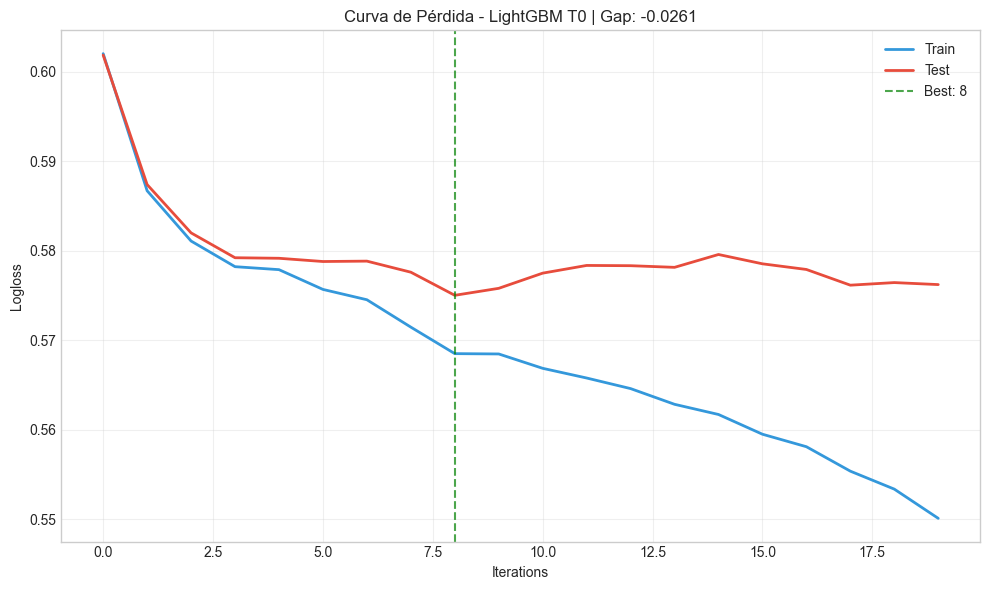

2026/02/18 07:16:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrica           Train       Test        Gap
accuracy         0.7109     0.6757     0.0352
precision        0.5348     0.4964     0.0384
recall           0.7713     0.7289     0.0425
f1               0.6316     0.5906     0.0410
roc_auc          0.8105     0.7796     0.0309

--- Métricas por Clase (TEST) ---
Clase            Precision     Recall         F1    Support
No Desertor         0.8355     0.6506     0.7315        601
Desertor            0.4964     0.7289     0.5906        284


Successfully registered model 'lightgbm-final-val'.
2026/02/18 07:16:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm-final-val, version 1


🏃 View run LightGBM_mejor_modelo2 at: http://127.0.0.1:5000/#/experiments/294382465810157940/runs/b8c89f1940954df9a92d2576d3853eb7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/294382465810157940


Created version '1' of model 'lightgbm-final-val'.


In [32]:
results_T0 = entrena_y_evalua_lightgbm(X_train, X_test, y_train, y_test, 'T0', BEST_PARAMS['T0'])

### Fase T1

  ENTRENAMIENTO LIGHTGBM - FASE T1

Variables: 29
Train: 3539 | Test: 885

Hiperparámetros óptimos:
 - n_estimators: 28
 - learning_rate: 0.18686606480257353
 - num_leaves: 121
 - max_depth: 0
 - min_child_samples: 15
 - subsample: 0.8749768919580893
 - colsample_bytree: 0.6221551868900861
 - reg_alpha: 5.428592636110349
 - reg_lambda: 8.48024195729075
 - scale_pos_weight: 1.260274180982516

Entrenamiento de modelo final LightGBM


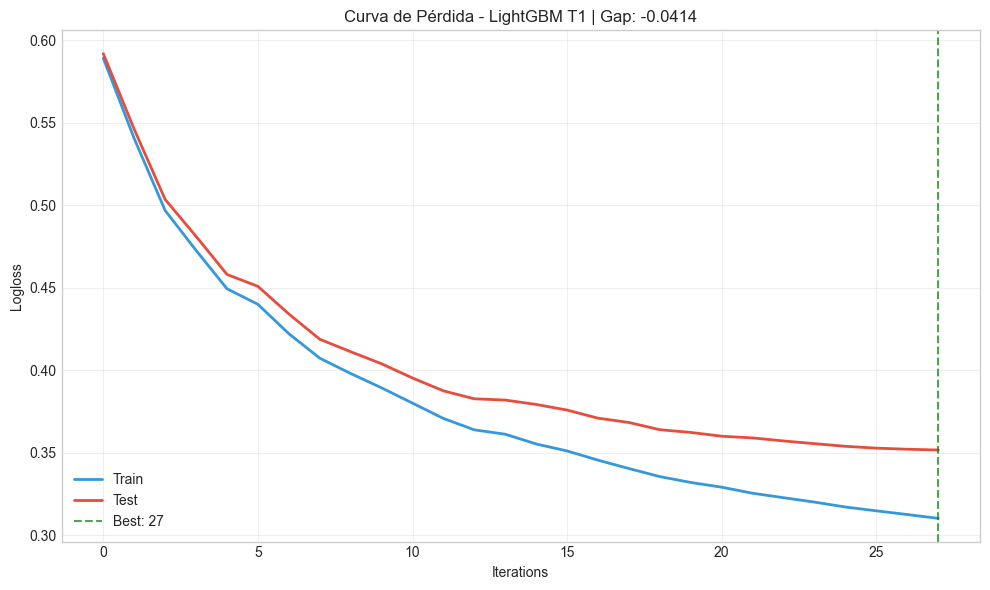

2026/02/18 07:16:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrica           Train       Test        Gap
accuracy         0.8776     0.8520     0.0257
precision        0.8444     0.7823     0.0621
recall           0.7590     0.7465     0.0125
f1               0.7994     0.7640     0.0355
roc_auc          0.9337     0.9029     0.0308

--- Métricas por Clase (TEST) ---
Clase            Precision     Recall         F1    Support
No Desertor         0.8827     0.9018     0.8922        601
Desertor            0.7823     0.7465     0.7640        284


Registered model 'lightgbm-final-val' already exists. Creating a new version of this model...
2026/02/18 07:16:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm-final-val, version 2


🏃 View run LightGBM_mejor_modelo2 at: http://127.0.0.1:5000/#/experiments/294382465810157940/runs/568be7206009492caf2c7ab473ae6ef7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/294382465810157940


Created version '2' of model 'lightgbm-final-val'.


In [33]:
results_T1 = entrena_y_evalua_lightgbm(X_train, X_test, y_train, y_test, 'T1', BEST_PARAMS['T1'])

### Fase T2

  ENTRENAMIENTO LIGHTGBM - FASE T2

Variables: 35
Train: 3539 | Test: 885

Hiperparámetros óptimos:
 - n_estimators: 28
 - learning_rate: 0.19717963132777555
 - num_leaves: 76
 - max_depth: 10
 - min_child_samples: 55
 - subsample: 0.9512667915560066
 - colsample_bytree: 0.6826798404497569
 - reg_alpha: 7.484119365975137
 - reg_lambda: 2.6529686670614416
 - scale_pos_weight: 1.449586545888672

Entrenamiento de modelo final LightGBM


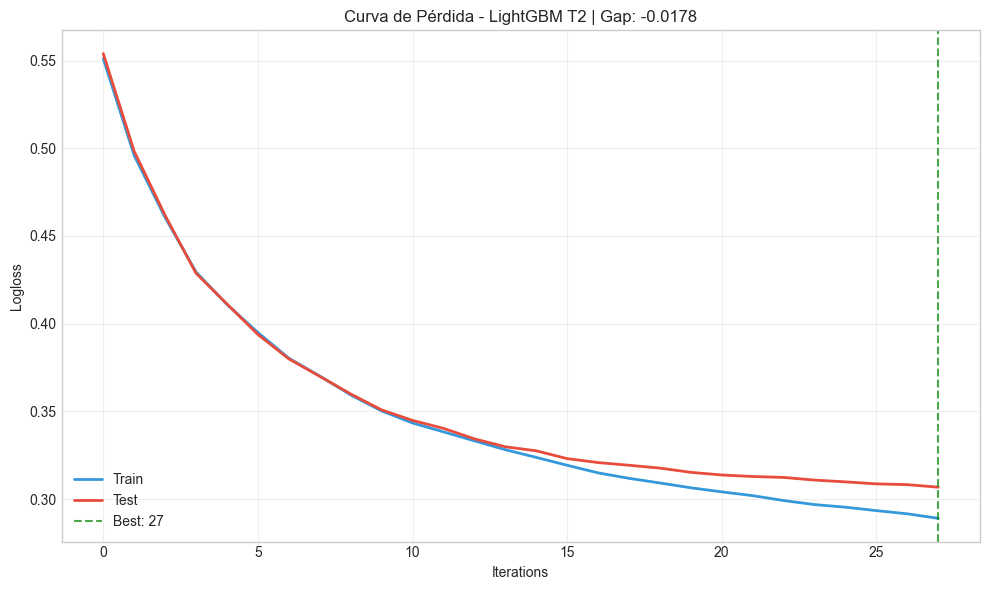

2026/02/18 07:16:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrica           Train       Test        Gap
accuracy         0.8881     0.8814     0.0067
precision        0.8466     0.8303     0.0163
recall           0.7960     0.7923     0.0037
f1               0.8205     0.8108     0.0097
roc_auc          0.9437     0.9302     0.0136

--- Métricas por Clase (TEST) ---
Clase            Precision     Recall         F1    Support
No Desertor         0.9039     0.9235     0.9136        601
Desertor            0.8303     0.7923     0.8108        284


Registered model 'lightgbm-final-val' already exists. Creating a new version of this model...
2026/02/18 07:16:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm-final-val, version 3


🏃 View run LightGBM_mejor_modelo2 at: http://127.0.0.1:5000/#/experiments/294382465810157940/runs/48fac03d15ad47a0a6fa9c668e69108c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/294382465810157940


Created version '3' of model 'lightgbm-final-val'.


In [34]:
results_T2 = entrena_y_evalua_lightgbm(X_train, X_test, y_train, y_test, 'T2', BEST_PARAMS['T2'])

## 7. Curva ROC Comparativa

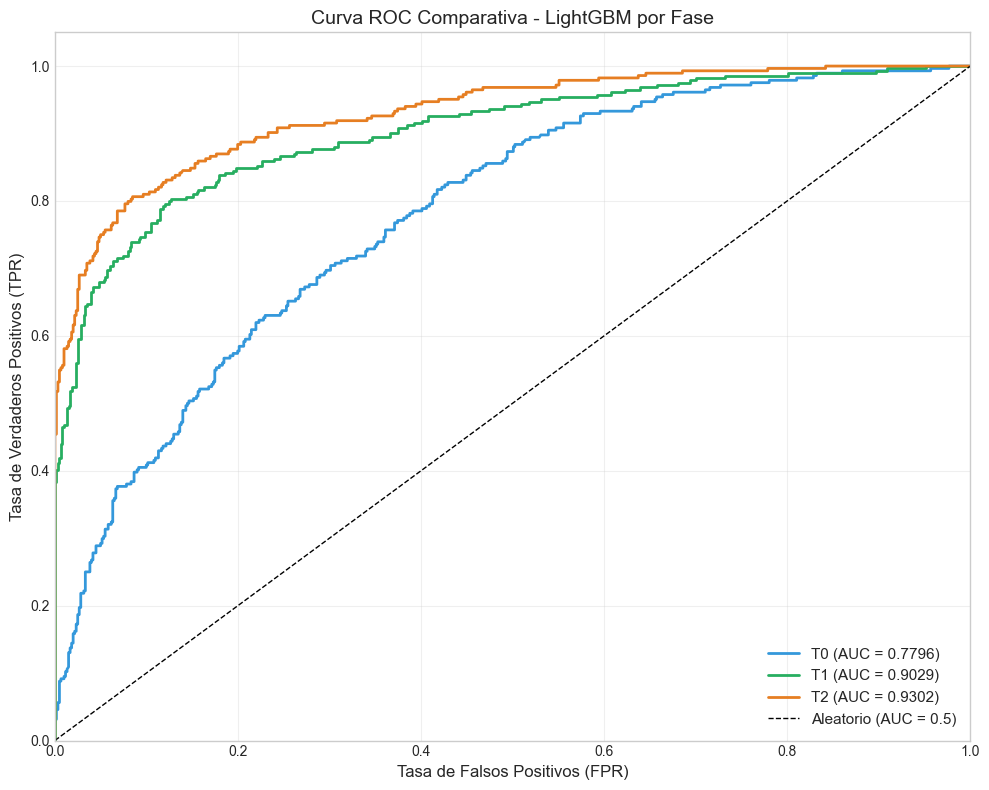

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'T0': '#3498DB', 'T1': '#27AE60', 'T2': '#E67E22'}

for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    ax.plot(results['roc']['fpr'], results['roc']['tpr'], 
            color=colors[fase], linewidth=2,
            label=f"{fase} (AUC = {results['roc']['auc']:.4f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aleatorio (AUC = 0.5)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
ax.set_title('Curva ROC Comparativa - LightGBM por Fase', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}curva_roc_comparativa.png', dpi=150)
plt.show()

## 8. Matriz de Confusión

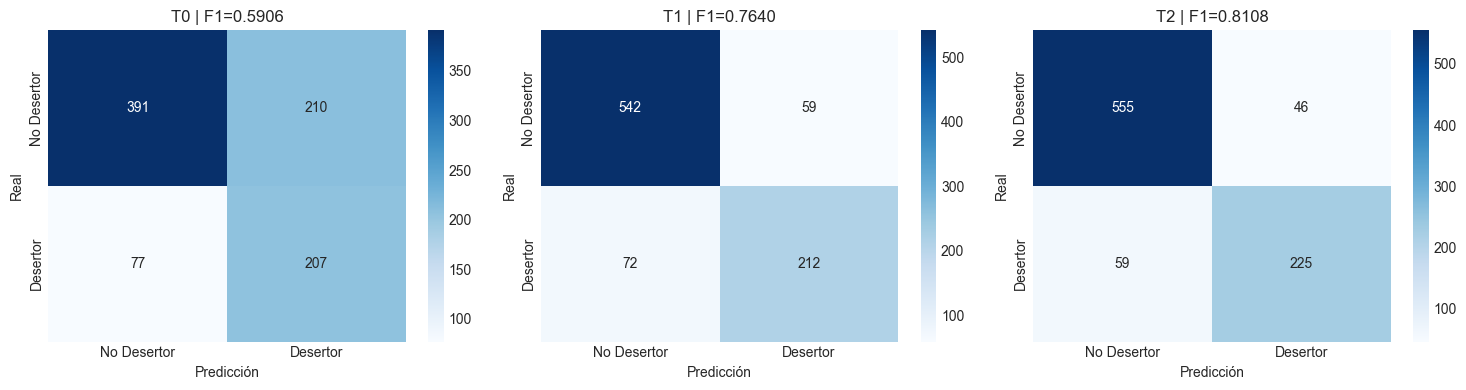

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (fase, results) in zip(axes, [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]):
    cm = confusion_matrix(y_test, results['y_test_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Desertor', 'Desertor'],
                yticklabels=['No Desertor', 'Desertor'])
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_title(f"{fase} | F1={results['metricas_test']['f1']:.4f}")

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}matrices_confusion.png', dpi=150)
plt.show()

## 9. Tabla Comparativa Final

In [37]:
print("================================================================================")
print("  COMPARACIÓN GLOBAL - TEST")
print("================================================================================")
print(f"\n{'Fase':<6} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'ROC-AUC':>10} {'Gap Loss':>10}")
print("================================================================================")
for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    m = results['metricas_test']
    print(f"{fase:<6} {m['accuracy']:>10.4f} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f} {m['roc_auc']:>10.4f} {results['gap_loss']:>10.4f}")

print("================================================================================")
print("  MÉTRICAS POR CLASE - TEST")
print("================================================================================")
print(f"\n{'Fase':<6} {'Clase':<15} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("================================================================================")
for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    mc = results['metricas_por_clase']
    print(f"{fase:<6} {'No Desertor':<15} {mc['clase_0']['precision']:>10.4f} {mc['clase_0']['recall']:>10.4f} {mc['clase_0']['f1']:>10.4f} {mc['clase_0']['support']:>10}")
    print(f"{'':6} {'Desertor':<15} {mc['clase_1']['precision']:>10.4f} {mc['clase_1']['recall']:>10.4f} {mc['clase_1']['f1']:>10.4f} {mc['clase_1']['support']:>10}")
    print("================================================================================")

  COMPARACIÓN GLOBAL - TEST

Fase     Accuracy  Precision     Recall         F1    ROC-AUC   Gap Loss
T0         0.6757     0.4964     0.7289     0.5906     0.7796    -0.0261
T1         0.8520     0.7823     0.7465     0.7640     0.9029    -0.0414
T2         0.8814     0.8303     0.7923     0.8108     0.9302    -0.0178
  MÉTRICAS POR CLASE - TEST

Fase   Clase            Precision     Recall         F1    Support
T0     No Desertor         0.8355     0.6506     0.7315        601
       Desertor            0.4964     0.7289     0.5906        284
T1     No Desertor         0.8827     0.9018     0.8922        601
       Desertor            0.7823     0.7465     0.7640        284
T2     No Desertor         0.9039     0.9235     0.9136        601
       Desertor            0.8303     0.7923     0.8108        284


## 10. Guardar Modelos y Datos para SHAP

**Guarda todo para continuar con análisis SHAP sin re-entrenar**

In [40]:
print("================================================================================")
print("  GUARDANDO MODELOS Y DATOS")
print("================================================================================")

for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    # Modelo
    results['modelo'].booster_.save_model(f'{OUTPUT_DIR_MODELS}lightgbm_final_{fase}.txt')
    
    # Datos para SHAP
    datos = {
        'X_test_prep': results['X_test_prep'],
        'X_train_prep': results['X_train_prep'],
        'y_test': results['y_test'],
        'y_train': results['y_train'],
        'y_test_pred': results['y_test_pred'],
        'y_test_proba': results['y_test_proba'],
        'feature_names': results['preprocessors']['feature_names'],
        'metricas_train': results['metricas_train'],
        'metricas_test': results['metricas_test'],
        'metricas_por_clase': results['metricas_por_clase']
    }
    joblib.dump(datos, f'{OUTPUT_DIR_MODELS}datos_evaluacion_{fase}.joblib')
    joblib.dump(results['preprocessors'], f'{OUTPUT_DIR_MODELS}preprocessors_{fase}.joblib')
    
    print(f"{fase} guardado")

# Guardar params y métricas
with open(f'{OUTPUT_DIR_MODELS}best_params.json', 'w') as f:
    json.dump(BEST_PARAMS, f, indent=2)

metricas_all = []
for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    metricas_all.append({'fase': fase, 'dataset': 'train', **results['metricas_train']})
    metricas_all.append({'fase': fase, 'dataset': 'test', **results['metricas_test']})
pd.DataFrame(metricas_all).to_csv(f'{OUTPUT_DIR_MODELS}metricas_finales.csv', index=False)

print(f"\nParámetros y métricas guardados")
print("================================================================================")
print("  ARCHIVOS GENERADOS")
print("================================================================================")
print(f" - LightGBM_final_T0/T1/T2.cbm")
print(f" - Datos_evaluacion_T0/T1/T2.joblib")
print(f" - Metricas_finales.csv")

  GUARDANDO MODELOS Y DATOS
T0 guardado
T1 guardado
T2 guardado

Parámetros y métricas guardados
  ARCHIVOS GENERADOS
 - LightGBM_final_T0/T1/T2.cbm
 - Datos_evaluacion_T0/T1/T2.joblib
 - Metricas_finales.csv


## 11. Resumen 

In [41]:
print("\n================================================================================")
print("RESUMEN")
print("================================================================================")

print(f"""
MODELO RECOMENDADO: T1 (Fin 1er Semestre)

Métricas TEST
  - F1 Desertor:     {results_T1['metricas_por_clase']['clase_1']['f1']:.4f}
  - F1 No Desertor:  {results_T1['metricas_por_clase']['clase_0']['f1']:.4f}
  - ROC-AUC:         {results_T1['metricas_test']['roc_auc']:.4f}
  - Precision:       {results_T1['metricas_test']['precision']:.4f}
  - Recall:          {results_T1['metricas_test']['recall']:.4f}

Justificación
  • 6 meses de ventaja para intervención vs T2
  • Gap de pérdida: {results_T1['gap_loss']:.4f}
  • Variables académicas del 1er semestre altamente predictivas
""")


RESUMEN

MODELO RECOMENDADO: T1 (Fin 1er Semestre)

Métricas TEST
  - F1 Desertor:     0.7640
  - F1 No Desertor:  0.8922
  - ROC-AUC:         0.9029
  - Precision:       0.7823
  - Recall:          0.7465

Justificación
  • 6 meses de ventaja para intervención vs T2
  • Gap de pérdida: -0.0414
  • Variables académicas del 1er semestre altamente predictivas

